Plots environments into a single graph, in order to be put on the paper.

In [42]:
import sys
sys.path.append('../.')

import pandas as pd
from environment import Environment
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
plt.rcParams.update({'font.size': 22})

In [43]:
xian = Environment(Path(f"./xian"))
dilemma = Environment(Path(f"./dilemma_5x5"))

In [44]:
def calculate_agg_od(environment):
    """Calculate aggregate origin-destination flow matrix for each grid square of the given environment.

    Args:
        environment (Environment): environment for which to calcualte aggregate OD per grid square.

    Returns:
        torch.Tensor: aggregate od by grid
    """
    # 
    # A measure of importance of each square.
    agg_od_g = torch.zeros((environment.grid_x_size, environment.grid_y_size)).to(device)
    agg_od_v = environment.od_mx.sum(axis=1)
    # Get the grid indices.
    for i in range(agg_od_v.shape[0]):
        g = environment.vector_to_grid(torch.Tensor([i])).type(torch.int32)
        agg_od_g[g[0], g[1]] = agg_od_v[i]

    return agg_od_g

def calculate_price_groups(environment, bins):
    price_mx = environment.price_mx.clone().cpu().numpy()
    price_mx[price_mx <= 0] = np.nan
    bins = np.quantile(price_mx[~np.isnan(price_mx)], np.linspace(0, 1, bins + 1))[:-1]
    price_mx_binned = np.digitize(price_mx, bins).astype(np.float32)
    price_mx_binned[np.isnan(price_mx)] = np.nan

    return price_mx_binned

In [45]:
# Get aggregate ODs for each environment
xian_od = calculate_agg_od(xian).cpu()
dilemma_od = calculate_agg_od(dilemma).cpu()

# Get the price groups for each environment
xian_groups = calculate_price_groups(xian, 5)
dilemma_groups = calculate_price_groups(dilemma, 5)

c:\Users\Dimitris\Documents\GitHub\fair-network-expansion\environments\../.\environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (vector_idx // self.grid_x_size)


c:\Users\Dimitris\Documents\GitHub\fair-network-expansion\environments\../.\environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (vector_idx // self.grid_x_size)
c:\Users\Dimitris\Documents\GitHub\fair-network-expansion\environments\../.\environment.py:58: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  grid_x = (ve

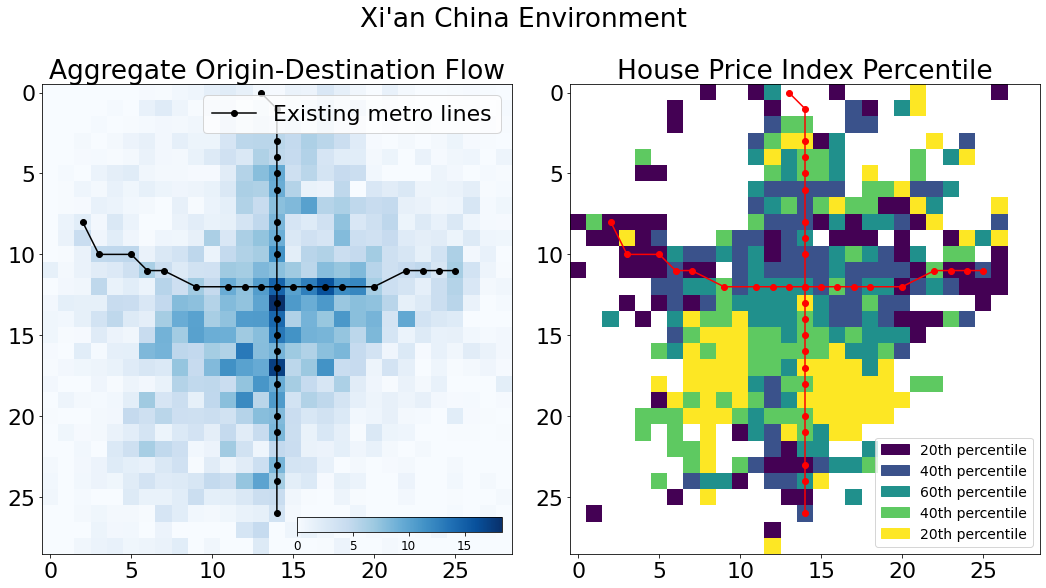

In [65]:
# def get_cax(ax):
#     divider = make_axes_locatable(ax)
#     return divider.append_axes('right', size='5%', pad=0.1)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(xian_od, cm.get_cmap('Blues'))
axs[0].set_title('Aggregate Origin-Destination Flow')
cax = fig.add_axes([0.29, 0.17, 0.19, 0.02])
fig.colorbar(im0, cax=cax, orientation='horizontal')
cax.tick_params(labelsize=12)

# axs[0].set_xticks(np.arange(-.5, 28, 1))
# axs[0].set_yticks(np.arange(-.5, 28, 1))
# axs[0].set_xticklabels(np.arange(0, 29, 1))
# axs[0].set_yticklabels(np.arange(0, 29, 1))
# axs[0].grid(color='gray', linewidth=1)


im1 = axs[1].imshow(xian_groups, cm.get_cmap('viridis'))
labels = ['20th percentile', '40th percentile', '60th percentile', '40th percentile', '20th percentile']
values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 14})
axs[1].set_title('House Price Index Percentile')
# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='vertical')

for i, l in enumerate(xian.existing_lines):
    l_v = xian.vector_to_grid(l.T).cpu()
    # Note here we reverse the dimensions because on scatter plots the horizontal axis is the x axis.
    label = "_no_legend"
    if i == 0:
        label = "Existing metro lines"

    axs[0].plot(l_v[1], l_v[0], '-ok', label=label)
    axs[1].plot(l_v[1], l_v[0], '-or', label=label)

axs[0].legend()

fig.suptitle("Xi'an China Environment", y=0.9)
fig.tight_layout()

C:\Users\Dimitris\AppData\Local\Temp\ipykernel_3496\2558275092.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


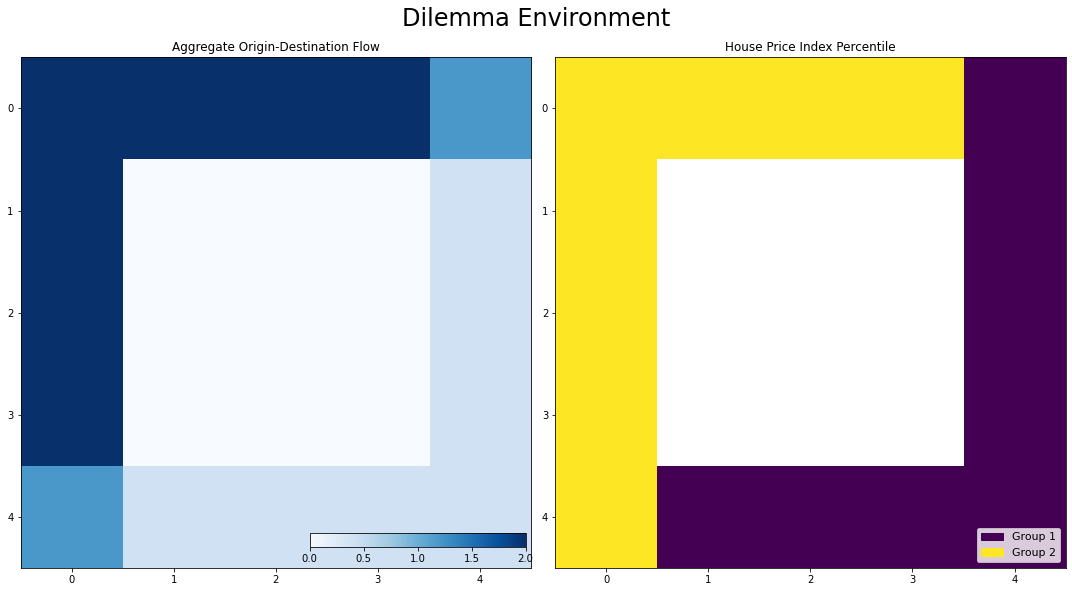

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

im0 = axs[0].imshow(dilemma_od, cm.get_cmap('Blues'))
cax = fig.add_axes([0.29, 0.15, 0.2, 0.02])
fig.colorbar(im0, cax=cax, orientation='horizontal')
axs[0].set_title('Aggregate Origin-Destination Flow')

im1 = axs[1].imshow(dilemma_groups, cm.get_cmap('viridis'))
labels = ['Group 1', 'Group 2']
values = (np.unique(dilemma_groups[~np.isnan(dilemma_groups)]))
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
axs[1].legend(handles=patches, loc="lower right", prop={'size': 11})
axs[1].set_title('House Price Index Percentile')

fig.suptitle("Dilemma Environment", y=0.9, fontsize=24)
fig.tight_layout()

In [30]:
# im2 = axs[2].imshow(diagonal_od)
# im3 = axs[3].imshow(diagonal_groups,  cm.get_cmap('viridis', 5))

# fig.colorbar(im1, cax=get_cax(axs[1]), orientation='horizontal', ticks=[1, 2, 3, 4, 5])
# fig.colorbar(im2, cax=get_cax(axs[2]), orientation='horizontal')
# fig.colorbar(im3, cax=get_cax(axs[3]), orientation='horizontal', ticks=[1, 2, 3, 4, 5]).ax.locator_params(nbins=5)



# labels = ['bottom 20%', 'bottom 40%', '60%', 'top 40%', 'top 20%']
# values = (np.unique(xian_groups[~np.isnan(xian_groups)]))
# colors = [ im1.cmap(im1.norm(value)) for value in values]
# patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
# axs[1].legend(handles=patches, ncol=len(values), loc="lower center", bbox_to_anchor=(0.5, -0.3))